In [1]:
# 코드 5-1 라이브러리 호출
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms  # 데이터 전처리를 위해 사용하는 라이브러리
from torch.utils.data import Dataset, DataLoader

/home/halozhan/딥러닝 파이토치 교과서/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 코드 5-2 CPU 혹은 GPU 장치 확인
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# 코드 5-3 fashion_mnist 데이터셋 내려받기
train_dataset = torchvision.datasets.FashionMNIST(
    "../chap05/data",
    download=True,
    transform=transforms.Compose([transforms.ToTensor()]),
)
test_dataset = torchvision.datasets.FashionMNIST(
    "../chap05/data",
    download=True,
    train=False,
    transform=transforms.Compose([transforms.ToTensor()]),
)  # 앞에서 훈련 데이터셋을 내려받았다면 여기에서는 테스트 데이터셋을 내려받습니다.

26422272it [00:09, 2881883.82it/s]                              


Extracting ../chap05/data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../chap05/data/FashionMNIST/raw



29696it [00:00, 103196.85it/s]                          


Extracting ../chap05/data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../chap05/data/FashionMNIST/raw



4422656it [00:02, 1591806.46it/s]                             


Extracting ../chap05/data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../chap05/data/FashionMNIST/raw



6144it [00:00, 15966421.17it/s]         

Extracting ../chap05/data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../chap05/data/FashionMNIST/raw




/home/halozhan/딥러닝 파이토치 교과서/.venv/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
# 코드 5-4 fashion_mnist 데이터를 데이터로더에 전달
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100)

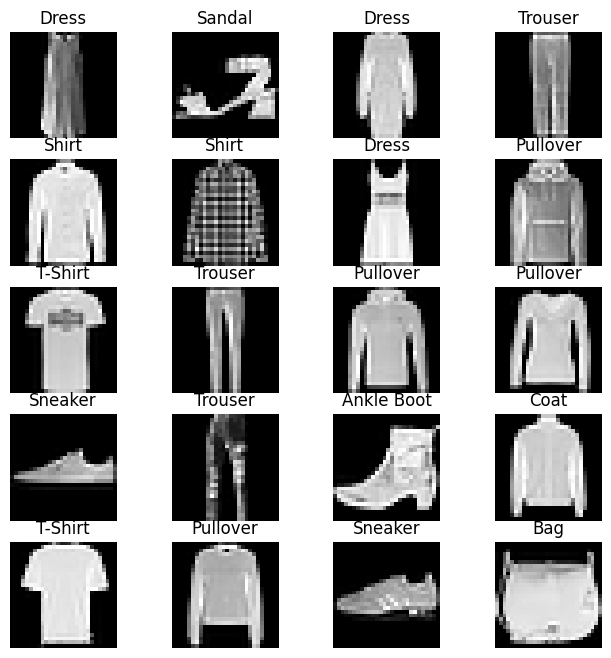

In [5]:
# 코드 5-5 분류에 사용될 클래스 정의
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}  # 열 개의 클래스

fig = plt.figure(figsize=(8, 8))
# 출력할 이미지의 가로세로 길이로 단위는 inch
columns = 4
rows = 5
for i in range(1, columns * rows + 1):
    img_xy = np.random.randint(len(train_dataset))
    img = train_dataset[img_xy][0][0, :, :]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()  # 20개의 이미지 데이터를 시각적으로 표현

In [6]:
# 코드 5-6 심층 신경망 모델 생성
class FashionDNN(nn.Module):
    def __init__(self):
        super(FashionDNN, self).__init__()
        self.fc1 = nn.Linear(in_features=784, out_features=256)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)

    def forward(self, input_data):
        out = input_data.view(-1, 784)
        out = F.relu(self.fc1(out))
        out = self.drop(out)
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [7]:
# 코드 5-7 심층 신경망에서 필요한 파라미터 정의
learning_rate = 0.001
model = FashionDNN()
model.to(device)

criterion = nn.CrossEntropyLoss()
# 분류 문제에서 사용하는 손실 함수
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [8]:
# 코드 5-8 심층 신경망을 이용한 모델 학습

num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)

        outputs = model(train)  # 학습 데이터를 모델에 적용
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1

        if not (count % 50):  # count를 50으로 나누었을 때 나머지가 0이 아니라면 실행
            total = 0
            correct = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                test = Variable(images.view(100, 1, 28, 28))
                outputs = model(test)
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)

            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if not (count % 500):
            print(
                "Iteration: {}, Loss: {}, Accuracy: {}%".format(
                    count, loss.data, accuracy
                )
            )

Iteration: 500, Loss: 0.612478494644165, Accuracy: 83.36000061035156%
Iteration: 1000, Loss: 0.49133816361427307, Accuracy: 84.1199951171875%
Iteration: 1500, Loss: 0.3704877495765686, Accuracy: 84.33999633789062%
Iteration: 2000, Loss: 0.34072113037109375, Accuracy: 85.68999481201172%
Iteration: 2500, Loss: 0.25689584016799927, Accuracy: 85.93000030517578%
Iteration: 3000, Loss: 0.3514255881309509, Accuracy: 86.65999603271484%


In [9]:
# 코드 5-9 합성곱 네트워크 생성


class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc1 = nn.Linear(in_features=64 * 6 * 6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(
            in_features=120, out_features=10
        )  # 마지막 계층의 out_features는 클래스 개수를 의미

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

In [10]:
# 코드 5-10 합성곱 네트워크를 위한 파라미터 정의
learning_rate = 0.001
model = FashionCNN()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [11]:
# 코드 5-11 모델 학습 및 성능 평가
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)

        outputs = model(train)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1

        if not (count % 50):
            total = 0
            correct = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                test = Variable(images.view(100, 1, 28, 28))
                outputs = model(test)
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)

            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if not (count % 500):
            print(
                "Iteration: {}, Loss: {}, Accuracy: {}%".format(
                    count, loss.data, accuracy
                )
            )

Iteration: 500, Loss: 0.4830019474029541, Accuracy: 87.61000061035156%
Iteration: 1000, Loss: 0.34093186259269714, Accuracy: 86.16999816894531%
Iteration: 1500, Loss: 0.2934156656265259, Accuracy: 86.8499984741211%
Iteration: 2000, Loss: 0.2948993742465973, Accuracy: 89.16999816894531%
Iteration: 2500, Loss: 0.12090893089771271, Accuracy: 89.80999755859375%
Iteration: 3000, Loss: 0.15505199134349823, Accuracy: 90.32999420166016%
